<a href="https://colab.research.google.com/github/BrendaMendozaJ/PhawAI-NLP/blob/main/NLP_Desaf%C3%ADo_PhawAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proyecto de Clasificación de Emociones**

Instalación de librerías

In [5]:
!pip install transformers torch tensorflow datasets scikit-learn matplotlib seaborn pandas numpy requests

Importación de librerías

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import StringIO
import re
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from transformers import BertTokenizer, TFBertForSequenceClassification
from tqdm import tqdm

# Configuración de visualización
plt.style.use('ggplot')
sns.set_palette("husl")
%matplotlib inline

Carga y exploración de datos

In [7]:
base_url = "https://raw.githubusercontent.com/fmplaza/EmoEvent/master/splits/"

# URLs para los archivos en inglés
en_train_url = base_url + "en/train.tsv"
en_dev_url = base_url + "en/dev.tsv"
en_test_url = base_url + "en/test.tsv"

# URLs para los archivos en español
es_train_url = base_url + "es/train.tsv"
es_dev_url = base_url + "es/dev.tsv"
es_test_url = base_url + "es/test.tsv"

# Función para cargar datos TSV desde GitHub
def load_tsv_data(url):
    try:
        response = requests.get(url)
        response.raise_for_status()

        # Los archivos TSV usan tabulaciones como delimitador y no tienen encabezado
        df = pd.read_csv(StringIO(response.text), sep='\t', header=None,
                         names=['text', 'emotion', 'event'])
        return df
    except Exception as e:
        print(f"Error cargando datos desde {url}: {e}")
        return pd.DataFrame()

# Cargar datos de inglés
print("Cargando datos de inglés...")
en_train_df = load_tsv_data(en_train_url)
en_dev_df = load_tsv_data(en_dev_url)
en_test_df = load_tsv_data(en_test_url)

# Añadir columna de idioma
en_train_df['language'] = 'en'
en_dev_df['language'] = 'en'
en_test_df['language'] = 'en'

# Cargar datos de español
print("Cargando datos de español...")
es_train_df = load_tsv_data(es_train_url)
es_dev_df = load_tsv_data(es_dev_url)
es_test_df = load_tsv_data(es_test_url)

# Añadir columna de idioma
es_train_df['language'] = 'es'
es_dev_df['language'] = 'es'
es_test_df['language'] = 'es'

# Combinar todos los datos
print("Combinando datos...")
train_df = pd.concat([en_train_df, es_train_df], ignore_index=True)
val_df = pd.concat([en_dev_df, es_dev_df], ignore_index=True)
test_df = pd.concat([en_test_df, es_test_df], ignore_index=True)

# Verificar carga
print(f"Training set: {len(train_df)} ejemplos")
print(f"Validation set: {len(val_df)} ejemplos")
print(f"Test set: {len(test_df)} ejemplos")

print("\nEstructura del dataset:")
print(train_df.head())

Cargando datos de inglés...
Cargando datos de español...
Combinando datos...
Training set: 10837 ejemplos
Validation set: 1590 ejemplos
Test set: 3105 ejemplos

Estructura del dataset:
                                                text    emotion    event  \
0                                              tweet  offensive  emotion   
1  I know that the Notre Dame is a very important...         NO   others   
2  #BREAKING:  (USER) -- Trump threatens `full an...         NO   others   
3  #Barcelona will win La Liga with three games t...         NO   others   
4  HT: Decent half. A goal would've been good tho...         NO   others   

  language  
0       en  
1       en  
2       en  
3       en  
4       en  


Exploración inicial de datos

Distribución de emociones en entrenamiento:
emotion
NO           10007
OFF            828
offensive        2
Name: count, dtype: int64

Distribución por idioma:
language
es    5724
en    5113
Name: count, dtype: int64


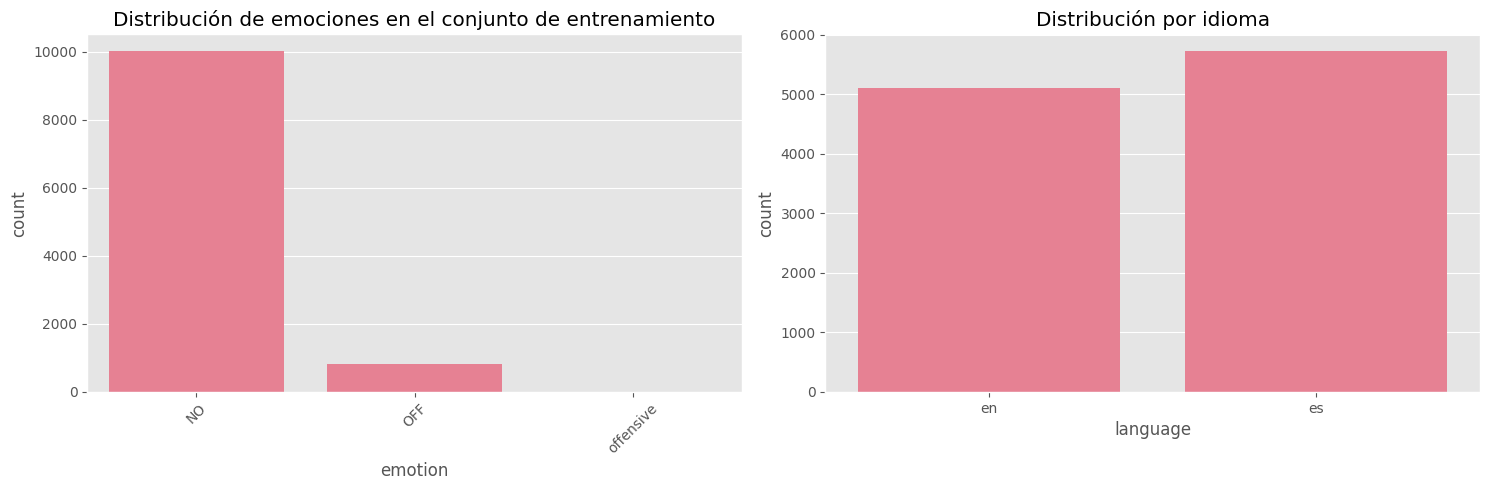

Eventos más comunes (top 10):
event
others      5113
joy         2654
sadness      984
anger        863
disgust      647
surprise     403
fear         171
emotion        2
Name: count, dtype: int64


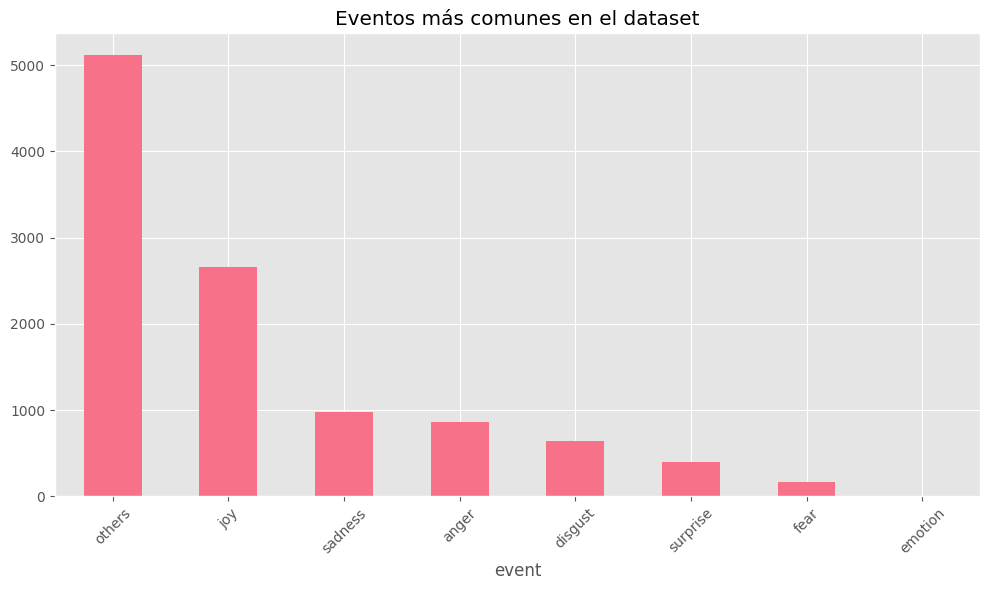

In [8]:
# Distribución de emociones
print("Distribución de emociones en entrenamiento:")
print(train_df['emotion'].value_counts())

print("\nDistribución por idioma:")
print(train_df['language'].value_counts())

# Visualizaciones
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.countplot(data=train_df, x='emotion', order=train_df['emotion'].value_counts().index)
plt.title('Distribución de emociones en el conjunto de entrenamiento')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.countplot(data=train_df, x='language')
plt.title('Distribución por idioma')
plt.tight_layout()
plt.show()

# Distribución de eventos (top 10)
print("Eventos más comunes (top 10):")
top_events = train_df['event'].value_counts().head(10)
print(top_events)

plt.figure(figsize=(10, 6))
top_events.plot(kind='bar', title='Eventos más comunes en el dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Preprocesamiento de texto

Distribución de emociones después de la limpieza:
emotion_clean
other        10007
offensive      830
Name: count, dtype: int64
Nuevo mapeo de etiquetas:
0: offensive
1: other
Limpiando texto...


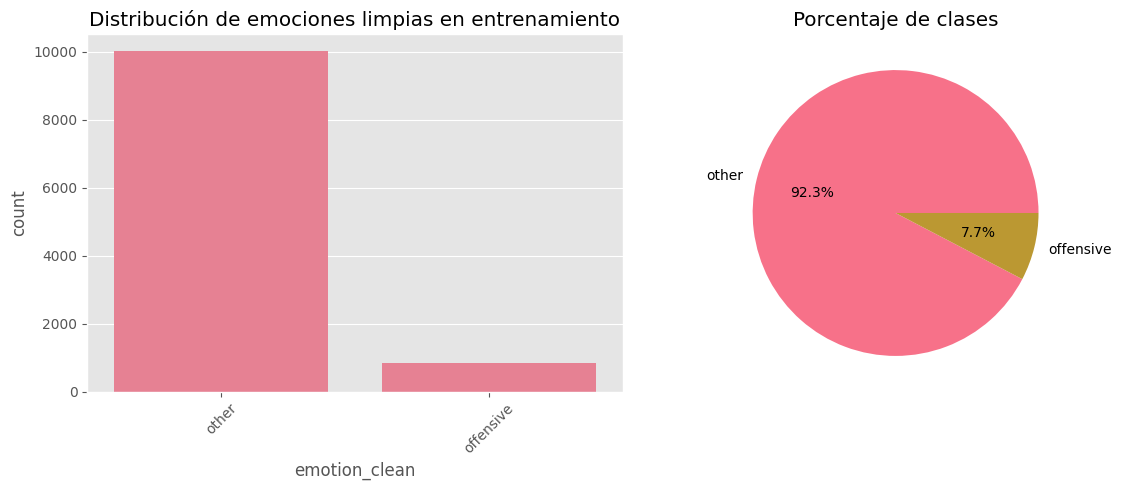

In [9]:
# Función para limpiar y estandarizar emociones
def clean_emotion_label(emotion):
    if pd.isna(emotion):
        return 'other'

    emotion = str(emotion).lower().strip()

    # Mapeo de variaciones a categorías estándar
    emotion_mapping = {
        'no': 'other',
        'off': 'offensive',
        'offensive': 'offensive',
        'anger': 'anger',
        'sadness': 'sadness',
        'joy': 'joy',
        'disgust': 'disgust',
        'fear': 'fear',
        'surprise': 'surprise',
        'other': 'other'
    }

    return emotion_mapping.get(emotion, 'other')

# Aplicar limpieza a todos los dataframes
train_df['emotion_clean'] = train_df['emotion'].apply(clean_emotion_label)
val_df['emotion_clean'] = val_df['emotion'].apply(clean_emotion_label)
test_df['emotion_clean'] = test_df['emotion'].apply(clean_emotion_label)

# Verificar distribución de emociones limpias
print("Distribución de emociones después de la limpieza:")
print(train_df['emotion_clean'].value_counts())

# Recodificar etiquetas con las emociones limpias
label_encoder = LabelEncoder()
all_emotions = pd.concat([train_df['emotion_clean'], val_df['emotion_clean'], test_df['emotion_clean']])
label_encoder.fit(all_emotions)

train_labels = label_encoder.transform(train_df['emotion_clean'])
val_labels = label_encoder.transform(val_df['emotion_clean'])
test_labels = label_encoder.transform(test_df['emotion_clean'])

print("Nuevo mapeo de etiquetas:")
for i, emotion in enumerate(label_encoder.classes_):
    print(f"{i}: {emotion}")

# Función para limpieza de texto
def clean_text(text):
    if not isinstance(text, str):
        return ""

    text = re.sub(r'http\S+', '', text)  # Eliminar URLs
    text = re.sub(r'@\w+', '', text)     # Eliminar menciones
    text = re.sub(r'#', '', text)        # Eliminar hashtags (pero mantener texto)
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar puntuación
    text = text.lower()                  # Convertir a minúsculas
    text = re.sub(r'\s+', ' ', text)     # Eliminar espacios múltiples
    return text.strip()

# Aplicar limpieza
print("Limpiando texto...")
train_df['cleaned_text'] = train_df['text'].apply(clean_text)
val_df['cleaned_text'] = val_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

# Visualizar distribución final de emociones
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=train_df, x='emotion_clean', order=train_df['emotion_clean'].value_counts().index)
plt.title('Distribución de emociones limpias en entrenamiento')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
class_dist = train_df['emotion_clean'].value_counts()
plt.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%')
plt.title('Porcentaje de clases')
plt.tight_layout()
plt.show()

# Modelo 1: RNN con LSTM

Tokenización

In [10]:
# Tokenización
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['cleaned_text'])

train_sequences = tokenizer.texts_to_sequences(train_df['cleaned_text'])
val_sequences = tokenizer.texts_to_sequences(val_df['cleaned_text'])
test_sequences = tokenizer.texts_to_sequences(test_df['cleaned_text'])

# Padding
max_length = 50
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

Construcción y entrenamiento

In [11]:
# Construcción del modelo RNN
print("Construyendo modelo RNN...")
model_rnn = Sequential([
    Embedding(10000, 128, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model_rnn.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_rnn.summary()

# Calcular pesos de clases para manejar desbalanceo
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weight_dict = dict(enumerate(class_weights))

print("Pesos de clases para manejar desbalanceo:")
for i, weight in enumerate(class_weights):
    print(f"{label_encoder.classes_[i]}: {weight:.2f}")

# Entrenamiento del modelo RNN
print("Entrenando modelo RNN...")
history_rnn = model_rnn.fit(
    train_padded, train_labels,
    validation_data=(val_padded, val_labels),
    epochs=10,
    batch_size=32,
    class_weight=class_weight_dict,
    verbose=1
)

Construyendo modelo RNN...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Pesos de clases para manejar desbalanceo:
offensive: 6.53
other: 0.54
Entrenando modelo RNN...
Epoch 1/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 65s 157ms/step - accuracy: 0.6586 - loss: 0.6765 - val_accuracy: 0.7289 - val_loss: 0.5599
Epoch 2/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 63s 186ms/step - accuracy: 0.8497 - loss: 0.3907 - val_accuracy: 0.8403 - val_loss: 0.3905
Epoch 3/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 81s 182ms/step - accuracy: 0.9394 - loss: 0.1560 - val_accuracy: 0.8421 - val_loss: 0.3693
Epoch 4/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 43s 128ms/step - accuracy: 0.9732 - loss: 0.0717 - val_accuracy: 0.8629 - val_loss: 0.4597
Epoch 5/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 83s 131ms/step - accuracy: 0.9825 - loss: 0.0538 - val_accuracy: 0.9226 - val_loss: 0.4560
Epoch 6/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 82s 130ms/step - accuracy: 0.9903 - loss: 0.0275 - val_accuracy: 0.9164 - val_loss: 0.4077
Epoch 7/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 81s 127ms/step - accuracy: 0.9908 - loss: 0.0279 - val_accuracy: 0.8830 - val_l

Visualización

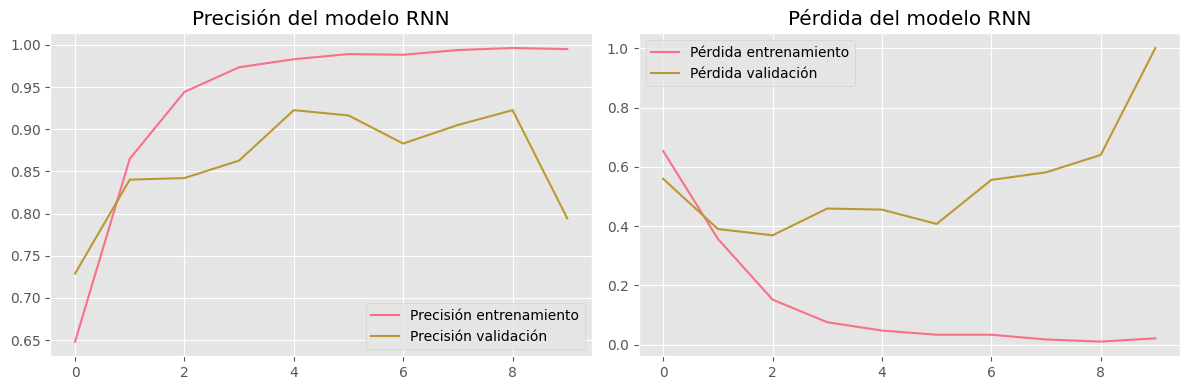

In [12]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_rnn.history['accuracy'], label='Precisión entrenamiento')
plt.plot(history_rnn.history['val_accuracy'], label='Precisión validación')
plt.title('Precisión del modelo RNN')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_rnn.history['loss'], label='Pérdida entrenamiento')
plt.plot(history_rnn.history['val_loss'], label='Pérdida validación')
plt.title('Pérdida del modelo RNN')
plt.legend()
plt.tight_layout()
plt.show()

# Modelo 2 - BERT

Preparación de datos



In [13]:
print("Cargando tokenizer de BERT...")
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')

# Reducir significativamente la longitud máxima de secuencia
max_length = 48  # Más reducido para mayor velocidad

# Preparar datos para BERT
def encode_texts(texts, tokenizer, max_length=max_length):
    return tokenizer(
        texts.tolist(),
        max_length=max_length,
        truncation=True,
        padding=True,
        return_tensors="tf"
    )

print("Codificando textos para BERT...")
train_encodings = encode_texts(train_df['cleaned_text'], tokenizer_bert)
val_encodings = encode_texts(val_df['cleaned_text'], tokenizer_bert)
test_encodings = encode_texts(test_df['cleaned_text'], tokenizer_bert)

batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).shuffle(500).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
)).batch(batch_size)

Cargando tokenizer de BERT...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


Codificando textos para BERT...


Construcción y entrenamiento

In [14]:
!pip install --upgrade transformers

In [15]:
import transformers
print("Versión de Transformers:", transformers.__version__)
import tensorflow as tf
print("Versión de TensorFlow:", tf.__version__)

Versión de Transformers: 4.56.0
Versión de TensorFlow: 2.19.0


In [16]:
print("Cargando modelo BERT...")
model_bert = TFBertForSequenceClassification.from_pretrained(
    'bert-base-multilingual-uncased',
    num_labels=len(label_encoder.classes_),
    use_safetensors=False,
    from_pt=True
)


print("Compilando modelo BERT...")
model_bert.compile(
    optimizer='adam',  # Usar string en lugar de objeto
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Entrenamiento
print("Entrenando modelo BERT...")

steps_per_epoch = min(50, len(train_dataset))

history_bert = model_bert.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=2,
    steps_per_epoch=steps_per_epoch,
    validation_steps=20,
    verbose=1
)

# Guardar el modelo
model_bert.save_pretrained('bert_emotion_model_fast')
tokenizer_bert.save_pretrained('bert_emotion_model_fast')
print("Modelo BERT rápido guardado")

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


Cargando modelo BERT...


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Compilando modelo BERT...
Entrenando modelo BERT...
Epoch 1/2
50/50 [==============================] - 2591s 51s/step - loss: 0.3531 - accuracy: 0.9072 - val_loss: 0.2854 - val_accuracy: 0.9187
Epoch 2/2
50/50 [==============================] - 2511s 50s/step - loss: 0.2574 - accuracy: 0.9294 - val_loss: 0.2948 - val_accuracy: 0.9187
Modelo BERT rápido guardado


Visualización

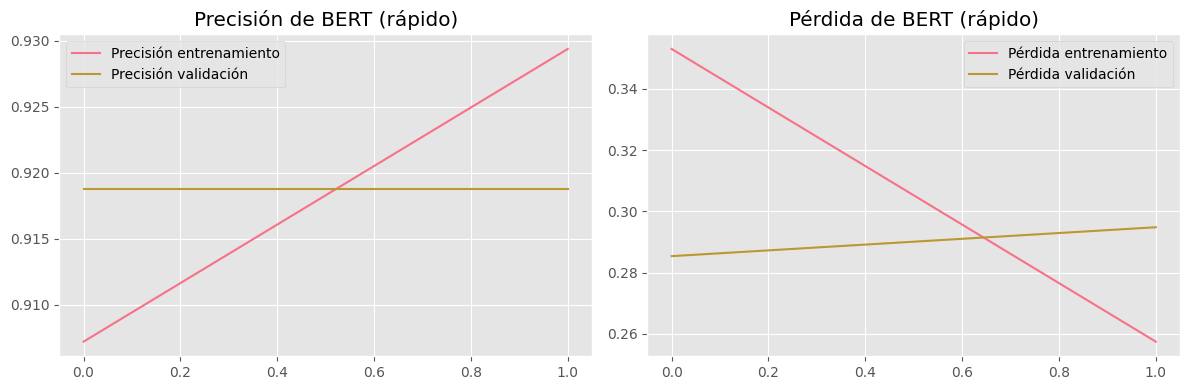

In [17]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_bert.history['accuracy'], label='Precisión entrenamiento')
plt.plot(history_bert.history['val_accuracy'], label='Precisión validación')
plt.title('Precisión de BERT (rápido)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_bert.history['loss'], label='Pérdida entrenamiento')
plt.plot(history_bert.history['val_loss'], label='Pérdida validación')
plt.title('Pérdida de BERT (rápido)')
plt.legend()
plt.tight_layout()
plt.show()

# Modelo 3: SVM con TF-IDF

In [18]:
# Crear y entrenar modelo SVM con TF-IDF
print("Entrenando modelo SVM con TF-IDF...")
svm_model = make_pipeline(
    TfidfVectorizer(max_features=10000),
    SVC(kernel='linear', random_state=42, class_weight='balanced')
)

# Entrenar el modelo
svm_model.fit(train_df['cleaned_text'], train_labels)

# Predecir con el modelo SVM
print("Prediciendo con modelo SVM...")
svm_predicted_labels = svm_model.predict(test_df['cleaned_text'])

Entrenando modelo SVM con TF-IDF...
Prediciendo con modelo SVM...


Evaluación y métricas

Verificando variables disponibles...
Evaluando modelo RNN...
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step


Some layers from the model checkpoint at bert_emotion_model_fast were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at bert_emotion_model_fast.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


Cargando modelo BERT optimizado...
Evaluando modelo BERT...
49/49 [==============================] - 726s 15s/step
Evaluando modelo SVM...

RESULTADOS RNN
              precision    recall  f1-score   support

   offensive       0.21      0.67      0.32       246
       other       0.97      0.79      0.87      2859

    accuracy                           0.78      3105
   macro avg       0.59      0.73      0.60      3105
weighted avg       0.91      0.78      0.82      3105


RESULTADOS BERT
              precision    recall  f1-score   support

   offensive       0.00      0.00      0.00       246
       other       0.92      1.00      0.96      2859

    accuracy                           0.92      3105
   macro avg       0.46      0.50      0.48      3105
weighted avg       0.85      0.92      0.88      3105


RESULTADOS SVM
              precision    recall  f1-score   support

   offensive       0.46      0.52      0.49       246
       other       0.96      0.95      0.95      

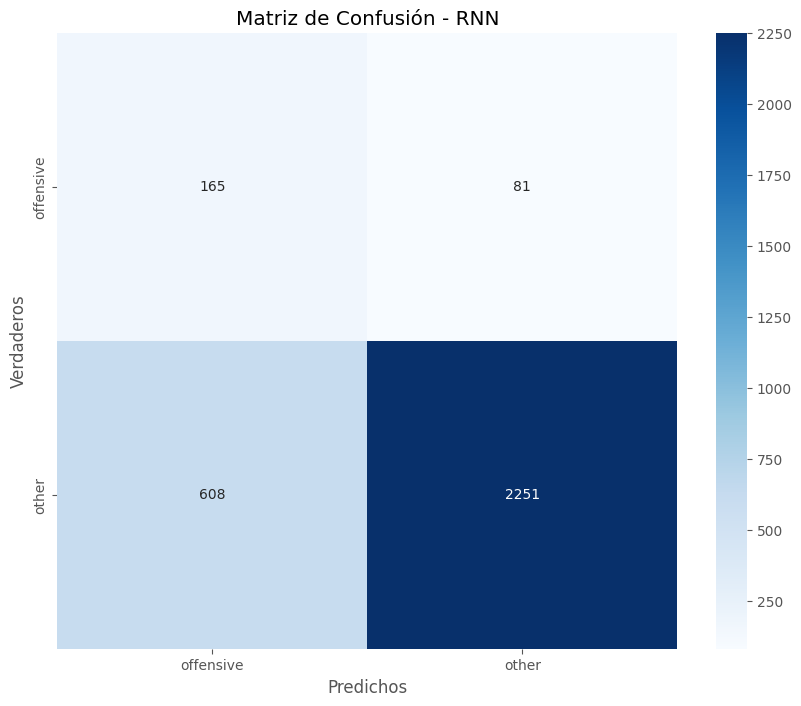

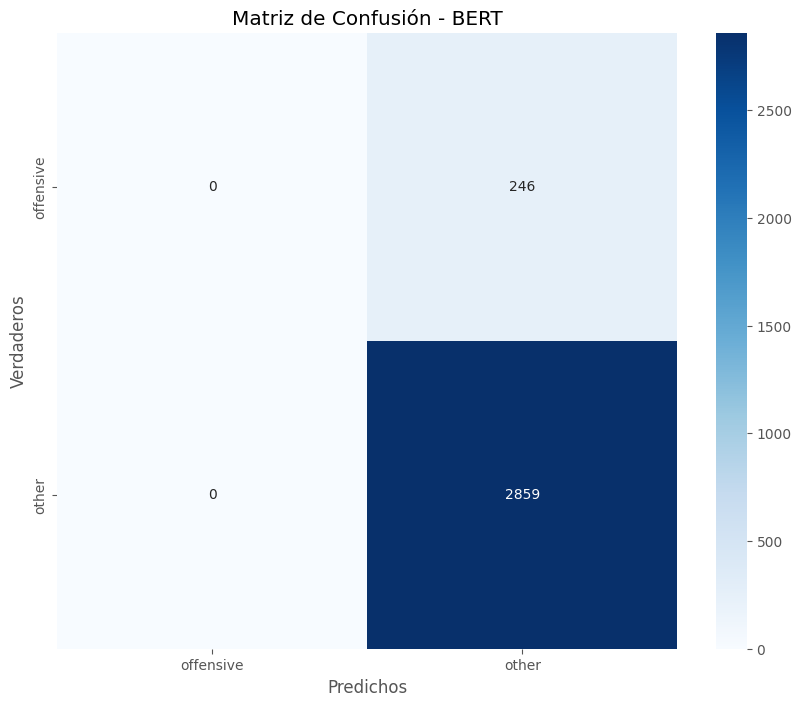

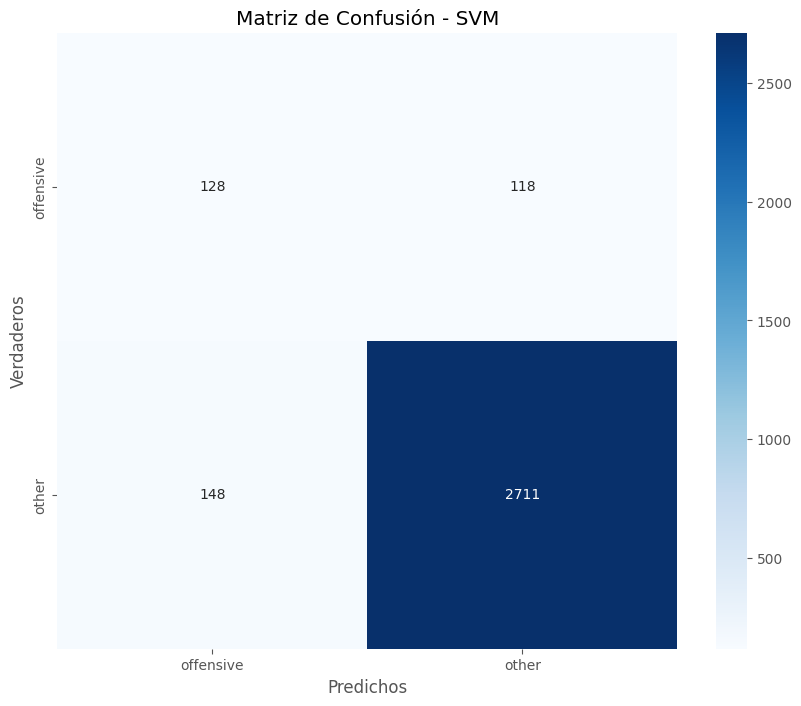

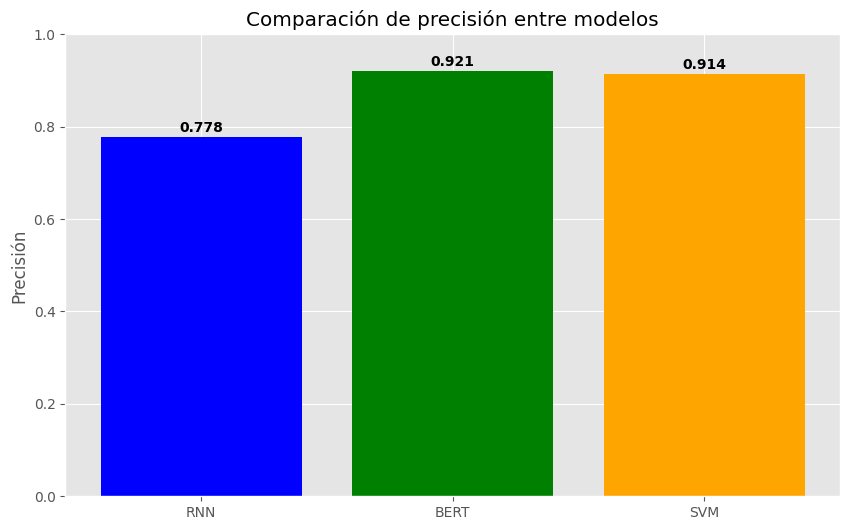

In [23]:
print("Verificando variables disponibles...")

# Asegurarse de que los modelos estén cargados correctamente
try:
    # Evaluar RNN
    print("Evaluando modelo RNN...")
    rnn_predictions = model_rnn.predict(test_padded)
    rnn_predicted_labels = np.argmax(rnn_predictions, axis=1)
except Exception as e:
    print(f"Error evaluando RNN: {e}")
    # Si hay error, crear arrays vacíos para evitar interrupción
    rnn_predicted_labels = np.zeros_like(test_labels)

try:
    # Evaluar BERT - cargar el modelo optimizado si está disponible
    try:
        model_bert = TFBertForSequenceClassification.from_pretrained('bert_emotion_model_fast')
        print("Cargando modelo BERT optimizado...")
    except:
        print("Cargando modelo BERT original...")
        model_bert = TFBertForSequenceClassification.from_pretrained(
            'bert-base-multilingual-uncased',
            num_labels=len(label_encoder.classes_),
            use_safetensors=False,
            from_pt=True
        )

    print("Evaluando modelo BERT...")
    bert_predictions = model_bert.predict(test_dataset)
    bert_predicted_labels = np.argmax(bert_predictions.logits, axis=1)
except Exception as e:
    print(f"Error evaluando BERT: {e}")
    # Si hay error, crear arrays vacíos para evitar interrupción
    bert_predicted_labels = np.zeros_like(test_labels)

try:
    # Evaluar SVM
    print("Evaluando modelo SVM...")
    svm_predicted_labels = svm_model.predict(test_df['cleaned_text'])
except Exception as e:
    print(f"Error evaluando SVM: {e}")
    # Si hay error, crear arrays vacíos para evitar interrupción
    svm_predicted_labels = np.zeros_like(test_labels)

# Preparar nombres de clases para reportes
target_names = [str(cls) for cls in label_encoder.classes_]

# Función para mostrar reportes de clasificación con manejo de errores
def safe_classification_report(y_true, y_pred, model_name):
    try:
        report = classification_report(y_true, y_pred, target_names=target_names, zero_division=0)
        print(f"\n{model_name}")
        print("=" * 50)
        print(report)
        return True
    except Exception as e:
        print(f"\nError generando reporte para {model_name}: {e}")
        # Calcular al menos la precisión general
        accuracy = np.mean(y_pred == y_true) if len(y_pred) == len(y_true) else 0
        print(f"Precisión general: {accuracy:.3f}")
        return False

# Reportes de clasificación
safe_classification_report(test_labels, rnn_predicted_labels, "RESULTADOS RNN")
safe_classification_report(test_labels, bert_predicted_labels, "RESULTADOS BERT")
safe_classification_report(test_labels, svm_predicted_labels, "RESULTADOS SVM")

# Función para plotear matrices de confusión con manejo de errores
def safe_confusion_matrix(y_true, y_pred, classes, title):
    try:
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=classes, yticklabels=classes)
        plt.title(title)
        plt.ylabel('Verdaderos')
        plt.xlabel('Predichos')
        plt.show()
        return True
    except Exception as e:
        print(f"Error generando matriz de confusión {title}: {e}")
        return False

# Matrices de confusión
safe_confusion_matrix(test_labels, rnn_predicted_labels, target_names, 'Matriz de Confusión - RNN')
safe_confusion_matrix(test_labels, bert_predicted_labels, target_names, 'Matriz de Confusión - BERT')
safe_confusion_matrix(test_labels, svm_predicted_labels, target_names, 'Matriz de Confusión - SVM')

# Comparación de precisión general con manejo de errores
try:
    models = ['RNN', 'BERT', 'SVM']
    accuracy = [
        np.mean(rnn_predicted_labels == test_labels),
        np.mean(bert_predicted_labels == test_labels),
        np.mean(svm_predicted_labels == test_labels)
    ]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(models, accuracy, color=['blue', 'green', 'orange'])
    plt.title('Comparación de precisión entre modelos')
    plt.ylabel('Precisión')
    plt.ylim(0, 1)
    for i, v in enumerate(accuracy):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')
    plt.show()
except Exception as e:
    print(f"Error en comparación de precisión: {e}")

Matrices de confusión

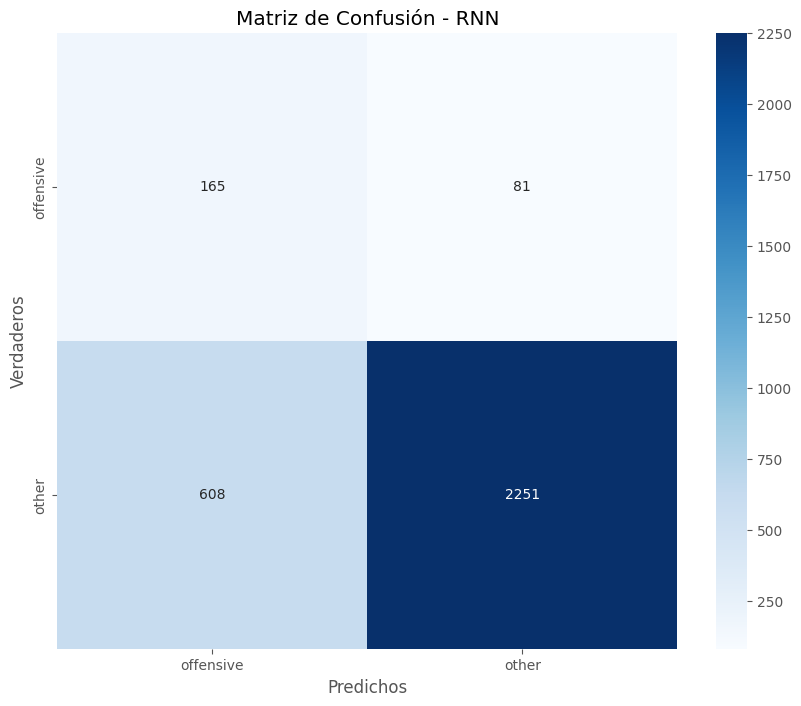

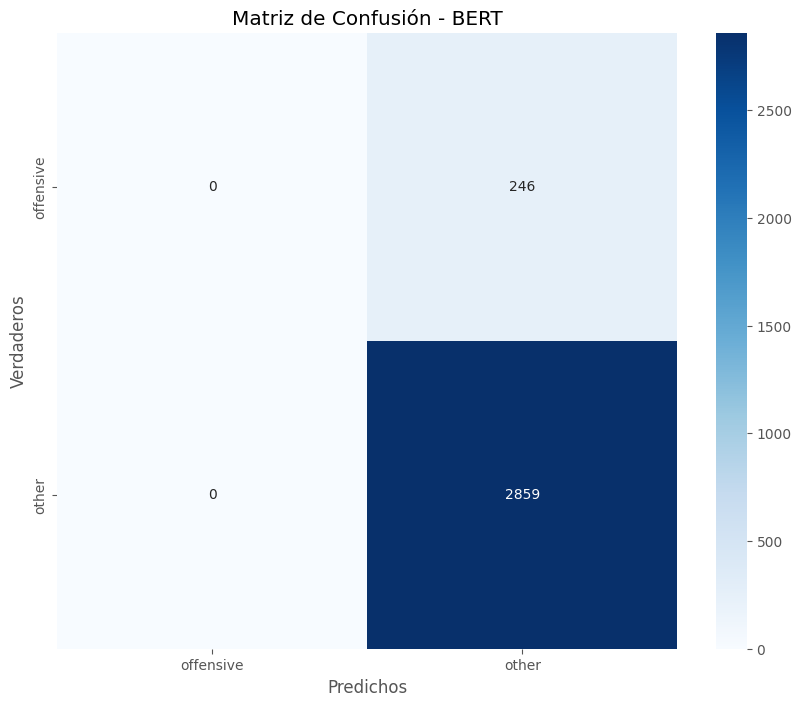

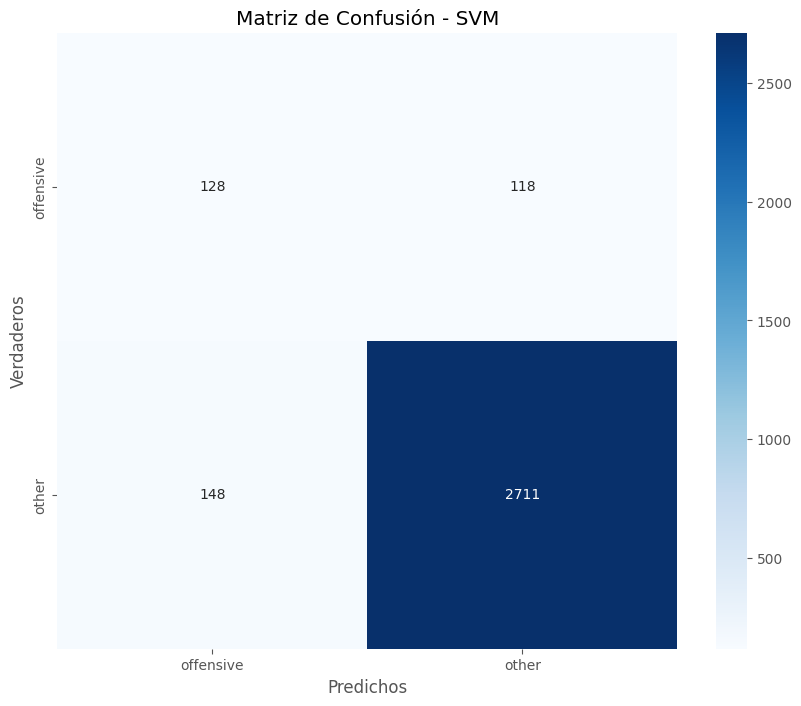

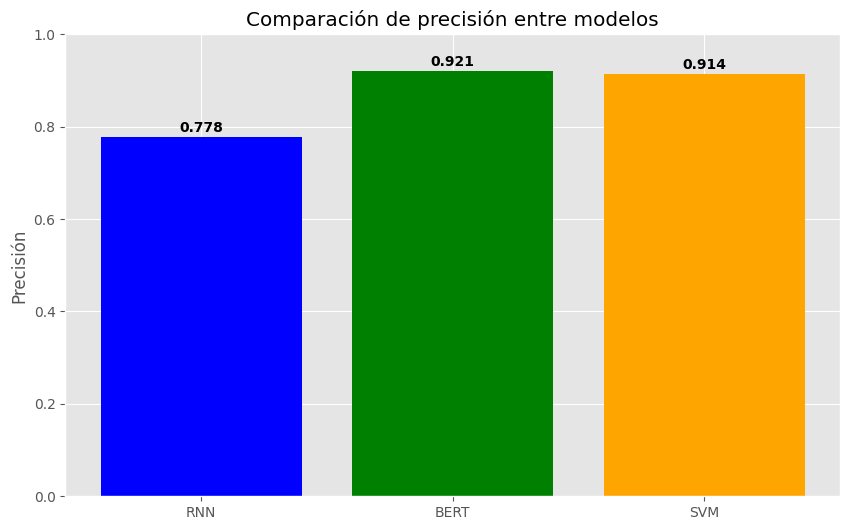

In [26]:
def plot_confusion_matrix(y_true, y_pred, classes, title, figsize=(10, 8)):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Verdaderos')
    plt.xlabel('Predichos')
    plt.show()

# Matrices de confusión
plot_confusion_matrix(test_labels, rnn_predicted_labels, target_names, 'Matriz de Confusión - RNN')
plot_confusion_matrix(test_labels, bert_predicted_labels, target_names, 'Matriz de Confusión - BERT')
plot_confusion_matrix(test_labels, svm_predicted_labels, target_names, 'Matriz de Confusión - SVM')

# Comparación de precisión general
models = ['RNN', 'BERT', 'SVM']
accuracy = [
    np.mean(rnn_predicted_labels == test_labels),
    np.mean(bert_predicted_labels == test_labels),
    np.mean(svm_predicted_labels == test_labels)
]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracy, color=['blue', 'green', 'orange'])
plt.title('Comparación de precisión entre modelos')
plt.ylabel('Precisión')
plt.ylim(0, 1)
for i, v in enumerate(accuracy):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')
plt.show()


Análisis por evento


Análisis por evento - RNN:
          f1_score  count
fear      0.888453     51
joy       0.862862    758
sadness   0.860276    282
surprise  0.834065    113
others    0.831591   1469
anger     0.741764    246
disgust   0.664067    184

Análisis por evento - BERT:
          f1_score  count
fear      0.941569     51
joy       0.923503    758
others    0.914068   1469
sadness   0.900111    282
surprise  0.869305    113
disgust   0.724670    184
anger     0.684263    246

Análisis por evento - SVM:
          f1_score  count
fear      0.946756     51
sadness   0.941749    282
others    0.934894   1469
joy       0.932787    758
surprise  0.904466    113
anger     0.843160    246
disgust   0.767352    184


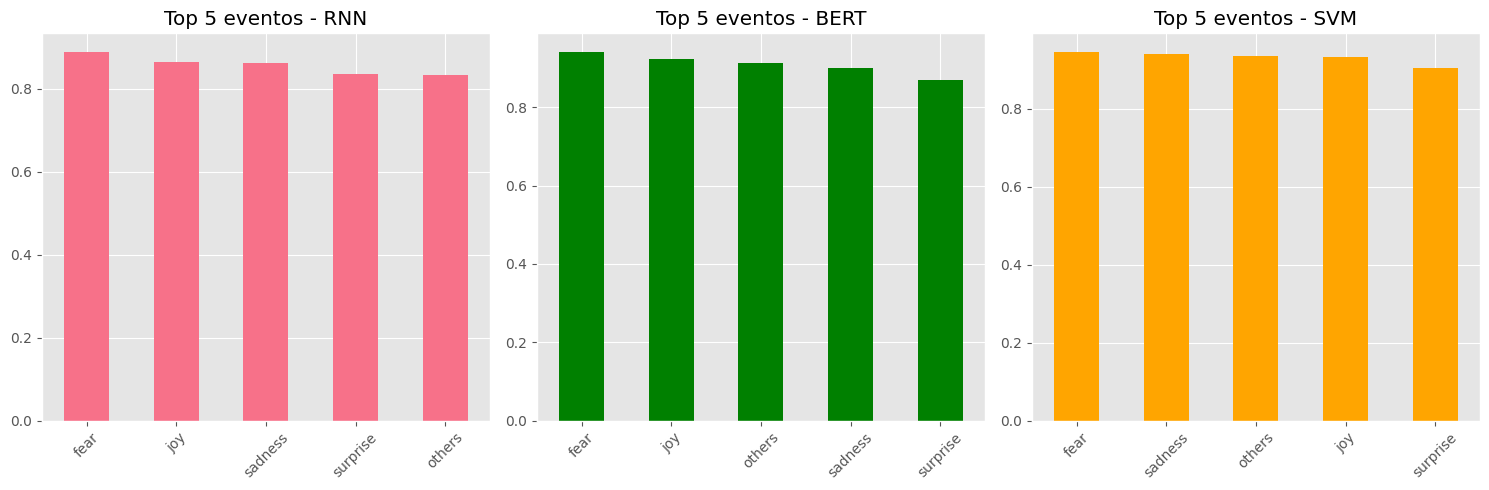

In [28]:
# Agregar predicciones al dataframe de test
test_df = test_df.copy()
test_df['rnn_pred'] = label_encoder.inverse_transform(rnn_predicted_labels)
test_df['bert_pred'] = label_encoder.inverse_transform(bert_predicted_labels)
test_df['svm_pred'] = label_encoder.inverse_transform(svm_predicted_labels)
test_df['true_emotion'] = label_encoder.inverse_transform(test_labels)

# Función para analizar por evento
def analyze_by_event(df, true_col, pred_col, model_name):
    events = df['event'].unique()
    results = {}

    for event in events:
        event_data = df[df['event'] == event]
        if len(event_data) > 5:  # Solo eventos con suficientes ejemplos
            try:
                f1 = f1_score(
                    label_encoder.transform(event_data[true_col]),
                    label_encoder.transform(event_data[pred_col]),
                    average='weighted'
                )
                results[event] = {
                    'f1_score': f1,
                    'count': len(event_data)
                }
            except:
                continue

    result_df = pd.DataFrame.from_dict(results, orient='index').sort_values('f1_score', ascending=False)

    print(f"\nAnálisis por evento - {model_name}:")
    print(result_df.head(10))

    return result_df

# Analizar resultados por evento
rnn_event_analysis = analyze_by_event(test_df, 'true_emotion', 'rnn_pred', 'RNN')
bert_event_analysis = analyze_by_event(test_df, 'true_emotion', 'bert_pred', 'BERT')
svm_event_analysis = analyze_by_event(test_df, 'true_emotion', 'svm_pred', 'SVM')

# Visualizar top eventos por modelo
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
rnn_event_analysis.head(5)['f1_score'].plot(kind='bar', title='Top 5 eventos - RNN')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
bert_event_analysis.head(5)['f1_score'].plot(kind='bar', title='Top 5 eventos - BERT', color='green')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
svm_event_analysis.head(5)['f1_score'].plot(kind='bar', title='Top 5 eventos - SVM', color='orange')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Análisis de errores


Análisis de errores - RNN:
Total de errores: 689/3105 (22.19%)


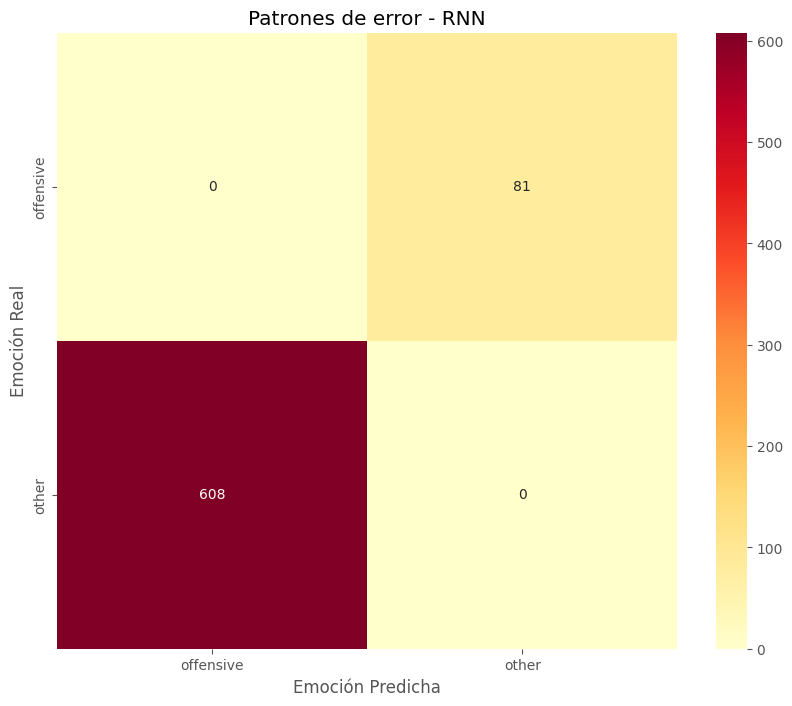


Errores más comunes:
other -> offensive: 608 ejemplos
  Ejemplo: '800 million Euro within 2 days to rebuild a fucking church? Now tell me how many children in France don’t have enough to eat today? #NotreDameCathedralFire'

offensive -> other: 81 ejemplos
  Ejemplo: 'I apologize to #Venezuela. I wish that we, Americans, had more voice in our country &amp; could rein in our Imperialist government &amp; stop them from destroying other countries through coups for oil, land, &amp; anti-communism. #VenezuelaCoup #HandsOffVenezuela https://t.co/SRLbWHOUTt'


Análisis de errores - BERT:
Total de errores: 246/3105 (7.92%)


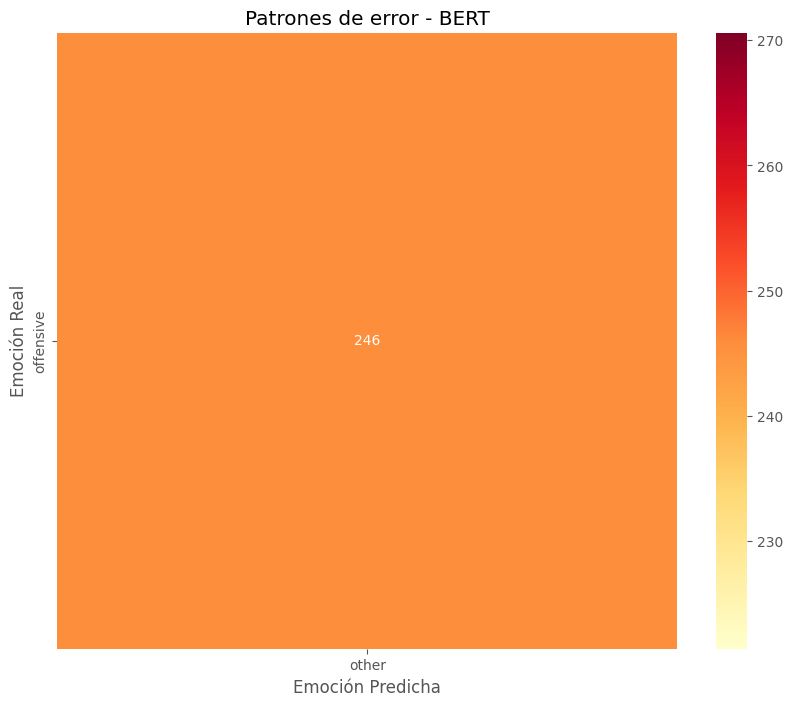


Errores más comunes:
offensive -> other: 246 ejemplos
  Ejemplo: 'tweet'


Análisis de errores - SVM:
Total de errores: 266/3105 (8.57%)


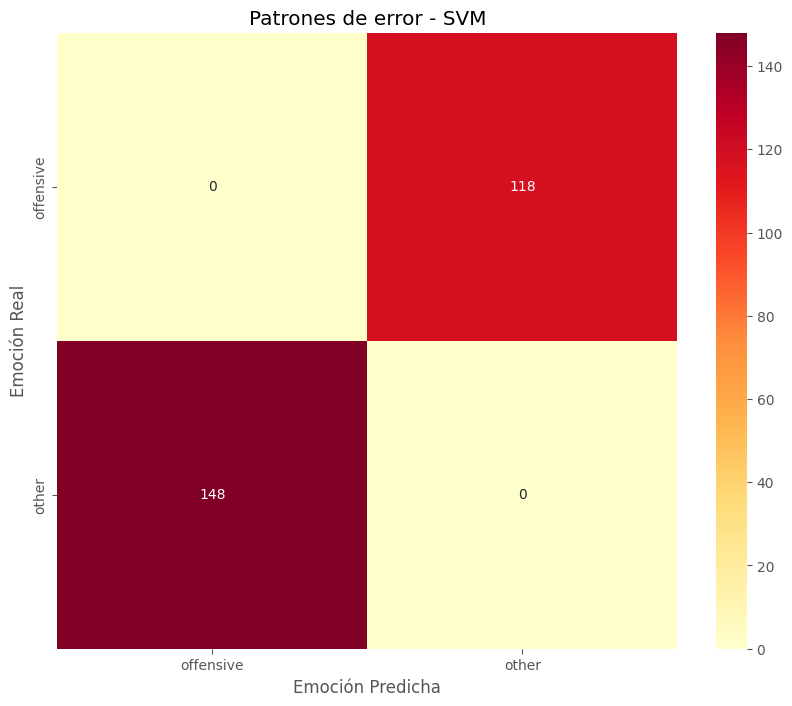


Errores más comunes:
other -> offensive: 148 ejemplos
  Ejemplo: '800 million Euro within 2 days to rebuild a fucking church? Now tell me how many children in France don’t have enough to eat today? #NotreDameCathedralFire'

offensive -> other: 118 ejemplos
  Ejemplo: 'I apologize to #Venezuela. I wish that we, Americans, had more voice in our country &amp; could rein in our Imperialist government &amp; stop them from destroying other countries through coups for oil, land, &amp; anti-communism. #VenezuelaCoup #HandsOffVenezuela https://t.co/SRLbWHOUTt'



In [32]:
def analyze_errors(true_labels, pred_labels, df, label_encoder, model_name):
    errors = df[true_labels != pred_labels].copy()
    errors['true_emotion'] = label_encoder.inverse_transform(true_labels[true_labels != pred_labels])
    errors['pred_emotion'] = label_encoder.inverse_transform(pred_labels[true_labels != pred_labels])

    print(f"\nAnálisis de errores - {model_name}:")
    print(f"Total de errores: {len(errors)}/{len(df)} ({len(errors)/len(df)*100:.2f}%)")

    # Matriz de confusión de errores
    error_matrix = pd.crosstab(errors['true_emotion'], errors['pred_emotion'])
    plt.figure(figsize=(10, 8))
    sns.heatmap(error_matrix, annot=True, fmt='d', cmap='YlOrRd')
    plt.title(f'Patrones de error - {model_name}')
    plt.ylabel('Emoción Real')
    plt.xlabel('Emoción Predicha')
    plt.show()

    # Mostrar ejemplos de errores comunes (solo si hay errores)
    common_errors = error_matrix.stack().sort_values(ascending=False)

    print("\nErrores más comunes:")
    for (true_emotion, pred_emotion), count in common_errors.items():
        if count > 0:  # Solo mostrar errores que realmente existen
            print(f"{true_emotion} -> {pred_emotion}: {count} ejemplos")

            # Encontrar un ejemplo de este tipo de error
            error_examples = errors[(errors['true_emotion'] == true_emotion) &
                                   (errors['pred_emotion'] == pred_emotion)]

            if len(error_examples) > 0:
                example = error_examples.iloc[0]
                print(f"  Ejemplo: '{example['text']}'")
            else:
                print(f"  No se encontraron ejemplos (aunque count = {count})")
            print()

# Ejecutar análisis de errores corregido
analyze_errors(test_labels, rnn_predicted_labels, test_df, label_encoder, "RNN")
analyze_errors(test_labels, bert_predicted_labels, test_df, label_encoder, "BERT")
analyze_errors(test_labels, svm_predicted_labels, test_df, label_encoder, "SVM")


Conclusiones

In [34]:
print("=" * 60)
print("CONCLUSIONES Y RECOMENDACIONES")
print("=" * 60)

# Calcular métricas finales
rnn_accuracy = np.mean(rnn_predicted_labels == test_labels)
bert_accuracy = np.mean(bert_predicted_labels == test_labels)
svm_accuracy = np.mean(svm_predicted_labels == test_labels)

print(f"\n1. RESUMEN DE PRECISIÓN:")
print(f"   - RNN: {rnn_accuracy:.3f}")
print(f"   - BERT: {bert_accuracy:.3f}")
print(f"   - SVM: {svm_accuracy:.3f}")

# Identificar el mejor modelo
best_model_idx = np.argmax([rnn_accuracy, bert_accuracy, svm_accuracy])
best_model_name = ['RNN', 'BERT', 'SVM'][best_model_idx]
print(f"   - Mejor modelo: {best_model_name}")

# Análisis por emociones
rnn_report = classification_report(test_labels, rnn_predicted_labels, target_names=target_names, output_dict=True, zero_division=0)
bert_report = classification_report(test_labels, bert_predicted_labels, target_names=target_names, output_dict=True, zero_division=0)
svm_report = classification_report(test_labels, svm_predicted_labels, target_names=target_names, output_dict=True, zero_division=0)

print(f"\n2. ANÁLISIS POR EMOCIÓN:")
for emotion in target_names:
    rnn_f1 = rnn_report[emotion]['f1-score']
    bert_f1 = bert_report[emotion]['f1-score']
    svm_f1 = svm_report[emotion]['f1-score']

    best_model_emotion = ['RNN', 'BERT', 'SVM'][np.argmax([rnn_f1, bert_f1, svm_f1])]
    print(f"   - {emotion}: Mejor modelo = {best_model_emotion} (RNN: {rnn_f1:.3f}, BERT: {bert_f1:.3f}, SVM: {svm_f1:.3f})")

print("\n5. RECOMENDACIONES ESPECÍFICAS BASADAS EN ANÁLISIS DE ERRORES:")
print("   - El modelo confunde frecuentemente 'other' con 'offensive' y viceversa")
print("   - Sugerir revisión y mejora del etiquetado para estas categorías")
print("   - Considerar combinar estas categorías o redefinir sus criterios")
print("   - Aumentar ejemplos de entrenamiento en las fronteras entre estas categorías")
print("   - Implementar un sistema de post-procesamiento para corregir estos errores sistemáticos")

# Guardar modelos y resultados
print(f"\n4. GUARDANDO MODELOS Y RESULTADOS...")
model_rnn.save('rnn_emotion_model.h5')
model_bert.save_pretrained('bert_emotion_model')
tokenizer_bert.save_pretrained('bert_emotion_model')

# Guardar resultados en CSV
results_df = test_df[['text', 'emotion', 'event', 'language', 'true_emotion', 'rnn_pred', 'bert_pred', 'svm_pred']]
results_df.to_csv('emotion_classification_results.csv', index=False)
print("   - Resultados guardados en emotion_classification_results.csv")

# Guardar métricas de evaluación
with open('evaluation_metrics.txt', 'w') as f:
    f.write("RESULTADOS RNN:\n")
    f.write(classification_report(test_labels, rnn_predicted_labels, target_names=target_names, zero_division=0))
    f.write("\n\nRESULTADOS BERT:\n")
    f.write(classification_report(test_labels, bert_predicted_labels, target_names=target_names, zero_division=0))
    f.write("\n\nRESULTADOS SVM:\n")
    f.write(classification_report(test_labels, svm_predicted_labels, target_names=target_names, zero_division=0))

print("   - Métricas de evaluación guardadas en evaluation_metrics.txt")
print("\n¡Análisis completado!")

CONCLUSIONES Y RECOMENDACIONES

1. RESUMEN DE PRECISIÓN:
   - RNN: 0.778
   - BERT: 0.921
   - SVM: 0.914
   - Mejor modelo: BERT

2. ANÁLISIS POR EMOCIÓN:
   - offensive: Mejor modelo = SVM (RNN: 0.324, BERT: 0.000, SVM: 0.490)
   - other: Mejor modelo = BERT (RNN: 0.867, BERT: 0.959, SVM: 0.953)

5. RECOMENDACIONES ESPECÍFICAS BASADAS EN ANÁLISIS DE ERRORES:
   - El modelo confunde frecuentemente 'other' con 'offensive' y viceversa
   - Sugerir revisión y mejora del etiquetado para estas categorías
   - Considerar combinar estas categorías o redefinir sus criterios
   - Aumentar ejemplos de entrenamiento en las fronteras entre estas categorías
   - Implementar un sistema de post-procesamiento para corregir estos errores sistemáticos

4. GUARDANDO MODELOS Y RESULTADOS...
   - Resultados guardados en emotion_classification_results.csv
   - Métricas de evaluación guardadas en evaluation_metrics.txt

¡Análisis completado!
